<a href="https://colab.research.google.com/github/MahlerTom/LiverSegmentation/blob/master/LiverSegmentationReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Liver Project

Advanced Medical Image Processing

March 2019

#Introduction

A fully automatic technique for segmenting the liver and localizing its unhealthy tissues is essential in many clinical applications, such as pathological diagnosis, surgical planning, and postoperative assessment. However, it is still a very challenging task due to the complex background, fuzzy boundary, and various appearance of both liver and liver lesions.

## Tasks
In this project we will develop automatic algorithms to segment liver and liver lesions in abdominal CT scans. To achieve this goal you'll utilize the power of deep learning algorithms.

The project consists of the following tasks:


1.   Liver segmentation
2.   Lesions segmentation


## Data

The training data set consists of 11 CT scans:

*   'Data' directory contains CT images converted to 'png' format
*   'Segmentation' directory contains segmentation masks:
    >* Pixels with value 127 indicate liver
    >* Pixels with value 255 indicate liver lesion

The data can be downloaded from the following link: [data link](https://drive.google.com/open?id=1lhYdOFymZSC5Gz76Zt4GzcDYc8nWaWJv).

## Evaluation metrics
The following metrics will be used to evaluate the segmentation accuracy:


*   Dice similarity coeffcient (Dice): 

>$Dice = \frac{2\times TP}{2\times TP+FP+FN}$

> TP, FP, and FN denote the number of true positive, false positive, and false negative pixels respectively. Dice computes a normalized overlap value between the produced and ground truth segmentation.

*   Precision (positive predictive rate):

>$Precision = \frac{TP}{TP + FP}$

>Precision expresses the proportion between the true segmented pixels and all pixels the model associates with liver / lesions.

*   Recall (sensitivity):

>$Recall = \frac{TP}{TP + FN}$

>Recall expresses the proportion between the true segmented pixels and all liver / lesions pixels.

# Installation

## `TensorFlow 2.0`

In this work, we are making use of [`TensorFlow 2.0`](https://www.tensorflow.org/alpha) API on `Google Colab` notebook set on GPU runtime (GPU: 1xTesla K80 , having 2496 CUDA cores, compute 3.7, 12GB (11.439GB Usable) GDDR5 VRAM). We load `TF2.0` as follows:

In [0]:
%%capture
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
# tf.enable_eager_execution()

In [2]:
print('Running on GPU' if tf.test.is_gpu_available() else 'Please change runtime type to GPU on Google Colab under Runtime') # Make sure we are set to GPU (under Runtime->Change runtime type)

Running on GPU


## Download the Dataset

The dataset was uploaded to [MahlerTom/LiverSegmentation](https://github.com/MahlerTom/LiverSegmentation), so we first need to clone the repository, with the data. To make things easier, we also define:

*   `repo_path` - the repository path (this should be cross platrform since we use `os` module)
*   `train_path` - the train dataset path
*   `val_path` - the test dataset path



In [0]:
%%capture
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/LiverSegmentation.git
repo_path = os.path.join(os.getcwd(), 'LiverSegmentation')
train_path = os.path.join(repo_path, 'data', 'train')
val_path = os.path.join(repo_path, 'data', 'val')

# Preparing the Dataset

Before we begin our training, we need to prepare the dataset. Since we are using TensorFlow 2.0, we will make use of its functions. We followed the guide at: [https://www.tensorflow.org/alpha/tutorials/load_data/images](https://www.tensorflow.org/alpha/tutorials/load_data/images)

<br>

Tensorflow makes use of smart functions that can load images given their paths. 

The data structure is as follows: 
```
(img_path, mask_path)
```

Thus, the following `load_data` function will create it.

In [0]:
import random
import IPython.display as display

def load_data(data_path, print_imgs=3):
  import pathlib
  
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
#   random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')  

  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join('/', *data_paths[0].split('/')[:-1])

  return data_paths

def image_name(path):
  return path.split('/')[-1][:-4]

Loaded 1092 image paths
##########################################
Printing Example Images



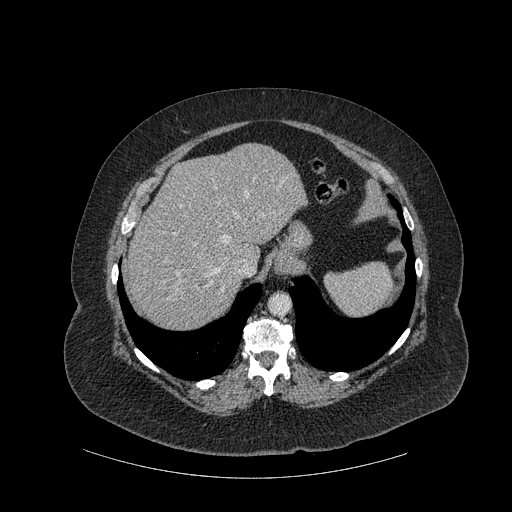

5_441



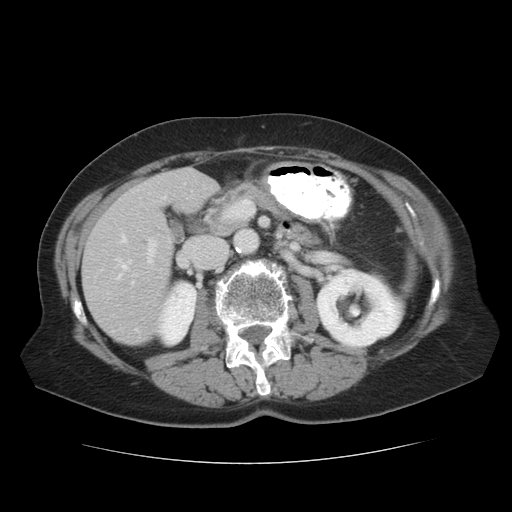

0_53



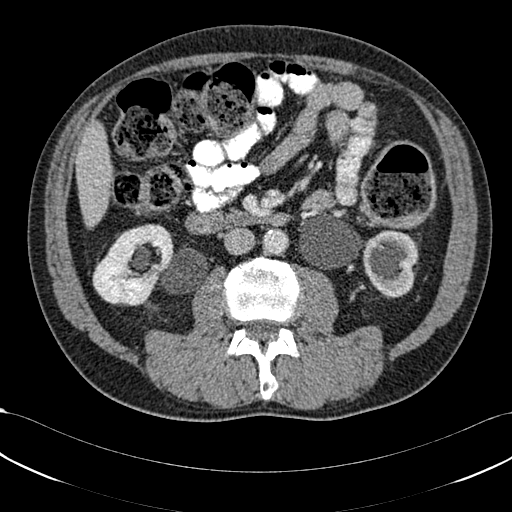

3_316

##########################################
Loaded 1092 image paths
##########################################
Printing Example Images



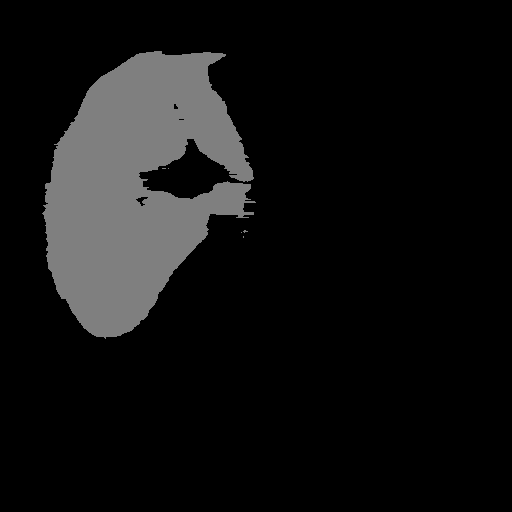

3_416



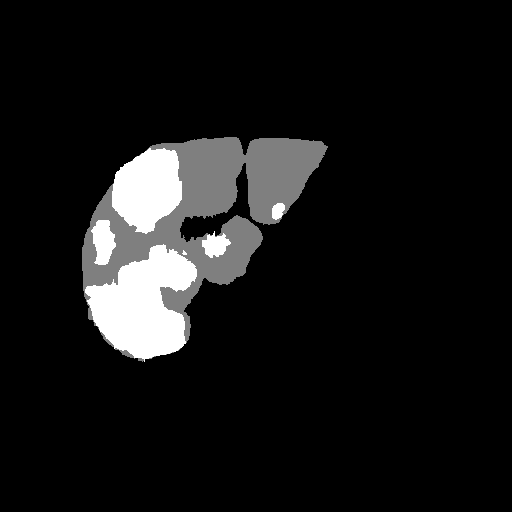

4_473



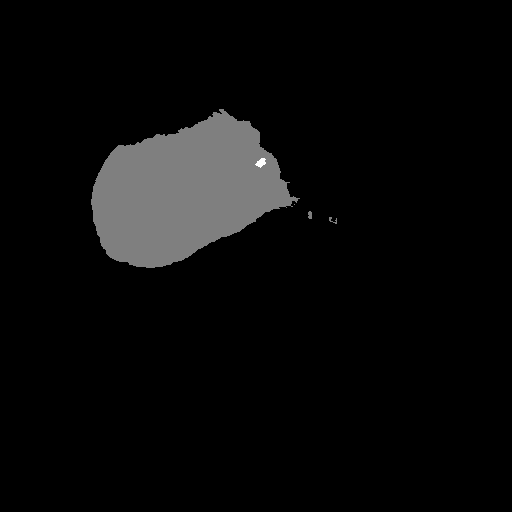

6_466

##########################################
Loaded 500 image paths
##########################################
Printing Example Images



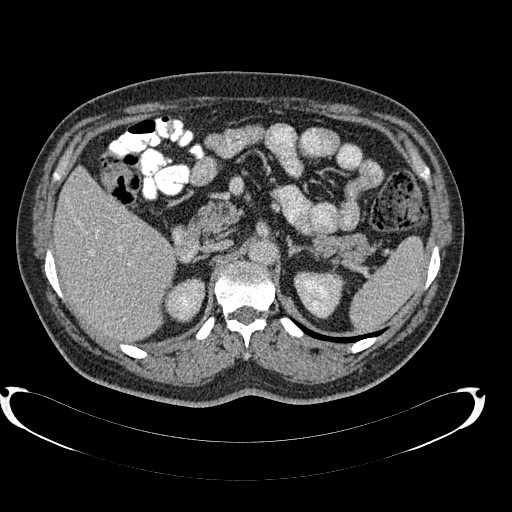

9_404



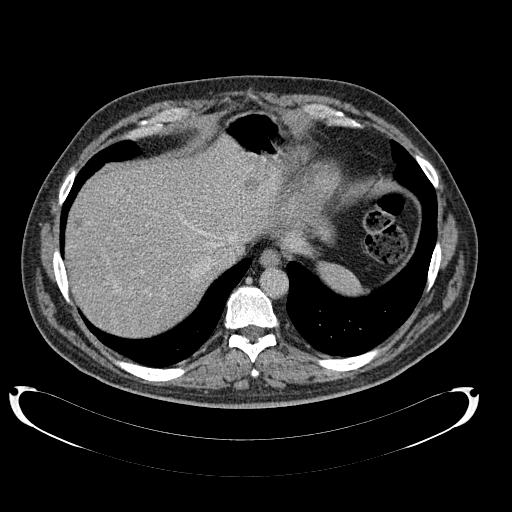

8_477



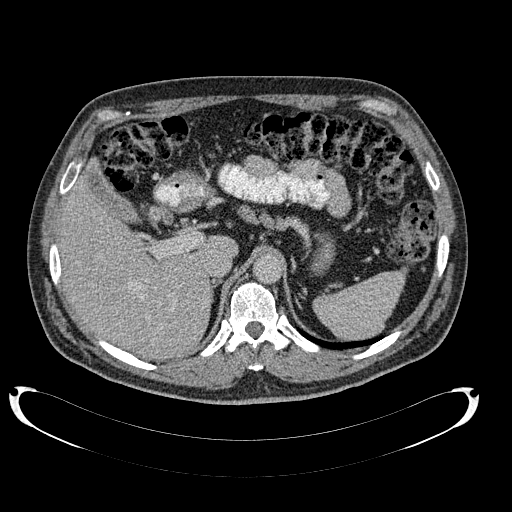

8_430

##########################################
Loaded 500 image paths
##########################################
Printing Example Images



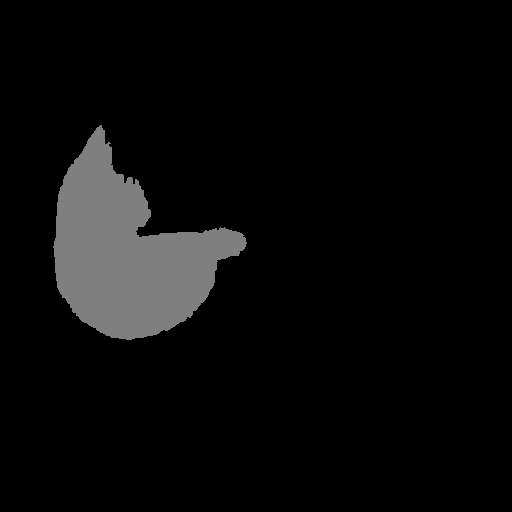

10_405



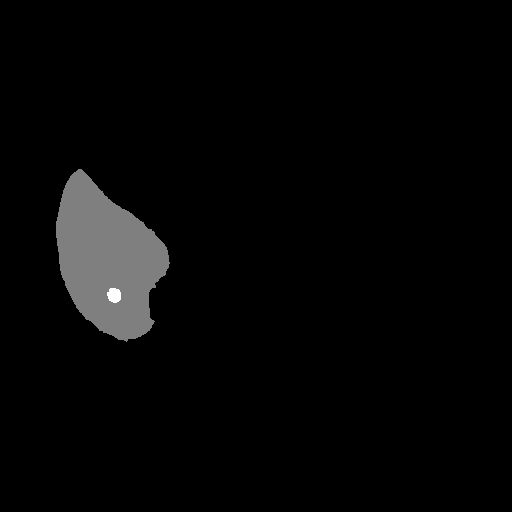

9_399



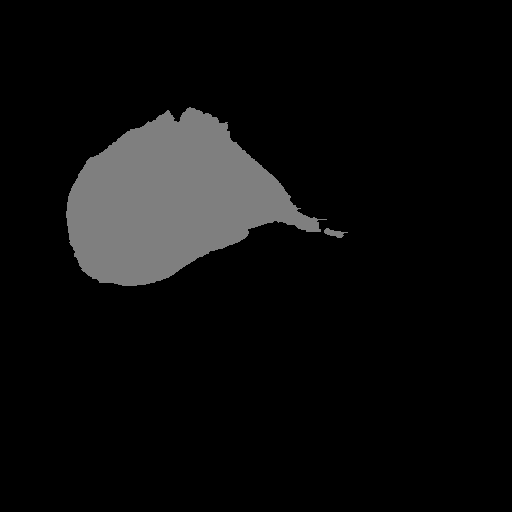

10_449

##########################################


In [5]:
# Loading the train images paths
train_images_paths = load_data(os.path.join(train_path, 'images'), print_imgs=3)

# Loading the train masks paths
train_masks_paths = load_data(os.path.join(train_path, 'masks'), print_imgs=3)

# Loading the validation images paths
val_images_paths = load_data(os.path.join(val_path, 'images'), print_imgs=3)

# Loading the validation masks paths
val_masks_paths = load_data(os.path.join(val_path, 'masks'), print_imgs=3)

## Load and Preprocess image using TF 2.0 [TODO]
These function loads images as tensors, and lay the groundwork for preprocessing

[TODO] add explanation of the functions

In [0]:
def preprocess_image(img_raw, norm=None, resize=None):
  # Decode png image into grayscale (channels = 1)
  img_tensor = tf.image.decode_png(img_raw, channels=1)
  if resize is not None:
    img_tensor = tf.image.resize(img_tensor, resize) # [192, 192]
  if norm is not None:
    img_tensor /= norm # 255.0
  return img_tensor
  
def load_and_preprocess_image(img_path, norm=None, resize=None):
  img_raw = tf.io.read_file(img_path)
  return preprocess_image(img_raw, norm=norm, resize=resize)

def load_and_preprocess_from_path_label(path, label, norm=None, resize=None):  
  return load_and_preprocess_image(path, norm=norm, resize=resize), load_and_preprocess_image(label, norm=norm, resize=resize)

## Creating Datasets using `tf.data.Dataset.from_tensor_slices`

In [0]:
def create_image_ds(image_paths, norm=None, resize=None):
  path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
  image_ds = path_ds.map(lambda path: load_and_preprocess_image(path, norm=norm, resize=resize), num_parallel_calls=AUTOTUNE)
  return image_ds

def create_ds(image_paths, mask_paths, norm=None, resize=None):
  ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
  label_ds = ds.map(
      lambda image_path, mask_path: load_and_preprocess_from_path_label(image_path, mask_path, norm=norm, resize=resize), 
      num_parallel_calls=AUTOTUNE
  )
  return label_ds

## Basic methods for training [TODO]
To train a model with this dataset you will want the data:

*   To be well shuffled.
*   To be batched.
*   To repeat forever.
*   Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [0]:
def prepare_ds(ds, batch_size, buffer_size, shuffle=True):
  # Setting a shuffle buffer size as large as the dataset ensures that the data is
  # completely shuffled.
  if shuffle:
    ds = ds.shuffle(buffer_size=buffer_size)
  ds = ds.repeat()
  ds = ds.batch(batch_size=batch_size)
  
  # `prefetch` lets the dataset fetch batches, in the background while the model is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# Define the model

## Model [TODO]

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet(pretrained_weights=None, shape=(256, 256, 1), filters=64):
    
    # First 3 layers
    inputs = Input(shape=shape, name='input') 
    conv1 = Conv2D(
        filters=filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv1_1'
    )(inputs)   
    conv1 = Conv2D(
        filters=filters, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv1_2'
    )(conv1)
    
    # Second 3 layers
    pool1 = MaxPooling2D(
        pool_size=2,
        name='pool2_0'
    )(conv1)
    conv2 = Conv2D(
        filters=filters*2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv2_1'
    )(pool1)
    conv2 = Conv2D(
        filters=filters*2,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2_2'
    )(conv2)
    
    # Third 3 layers
    pool2 = MaxPooling2D(
        pool_size=2,
        name='pool3_0'
    )(conv2)
    conv3 = Conv2D(
        filters=filters*4, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv3_1'
    )(pool2)
    conv3 = Conv2D(
        filters=filters*4, 
        kernel_size=3, 
        activation='relu',
        padding='same', 
        kernel_initializer='he_normal',
        name='conv3_2'
    )(conv3)
    
    # Fourth 3 layers
    pool3 = MaxPooling2D(
        pool_size=2,
        name='pool4_0'
    )(conv3)
    conv4 = Conv2D(
        filters=filters*8, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv4_1'
    )(pool3)
    conv4 = Conv2D(
        filters=filters*8,
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv4_2'
    )(conv4)
    
    # Fifth Dropout layers
    drop4 = Dropout(
        rate=0.5,
        name='drop5_0'
    )(conv4)
    
    # Fifth 3 layers
    pool4 = MaxPooling2D(
        pool_size=2,
        name='pool5_0'
    )(drop4)
    conv5 = Conv2D(
        filters=filters*16, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv5_1'
    )(pool4)
    conv5 = Conv2D(
        filters=filters*16, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv5_2'
    )(conv5)
    
    # sixth Dropout layers
    drop5 = Dropout(
        rate=0.5,
        name='drop6_0'
    )(conv5)
    
    # seventh concat layer
    up6 = Conv2D(
        filters=filters*8, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv7_concat'
    )(UpSampling2D(
        size=2,
        name='up7_concat'
    )(drop5))
    merge6 = concatenate(
        [drop4, up6], 
        axis=3,
        name='concat7_0'
    )
        
    # Rest of seventh layer
    conv6 = Conv2D(
        filters=filters*8, 
        kernel_size=3, 
        activation='relu', 
        padding='same',
        kernel_initializer='he_normal',
        name='conv7_1'
    )(merge6)
    conv6 = Conv2D(
        filters=filters*8, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv7_2'
    )(conv6)

    # Eighth concat layer
    up7 = Conv2D(
        filters=filters*4, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv8_concat'
    )(UpSampling2D(
        size=2,
        name='up8_concat'
    )(conv6))
    merge7 = concatenate(
        [conv3,up7],
        axis=3,
        name='concat8_0'
    )
    
    # Rest of eighth layer
    conv7 = Conv2D(
        filters=filters*4, 
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv8_1'
    )(merge7)
    conv7 = Conv2D(
        filters=filters*4, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv8_2'
    )(conv7)

    # Ninth concat layer
    up8 = Conv2D(
        filters=filters*2, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv9_concat'
    )(UpSampling2D(
        size=2,
        name='up9_concat'
    )(conv7))
    merge8 = concatenate(
        [conv2,up8], 
        axis=3,
        name='concat9_0'
    )
    
    # Rest of Ninth layer
    conv8 = Conv2D(
        filters=filters*2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv9_1'
    )(merge8)
    conv8 = Conv2D(
        filters=filters*2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv9_2'
    )(conv8)

    # Tenth concat layer
    up9 = Conv2D(
        filters=filters, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_concat'
    )(UpSampling2D(
        size=2,
        name='up10_concat'
    )(conv8))
    merge9 = concatenate(
        [conv1,up9],
        axis=3,
        name='concat10_0'
    )
    
    # Rest of Tenth layer
    conv9 = Conv2D(
        filters=filters,
        kernel_size=3,
        activation='relu',
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_1'
    )(merge9)
    conv9 = Conv2D(
        filters=filters, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_2'
    )(conv9)
    conv9 = Conv2D(
        filters=2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_3'
    )(conv9)
    
    
    conv10 = Conv2D(
        filters=1, 
        kernel_size=1, 
        activation='sigmoid', 
        name='conv11_0'
    )(conv9)
    
    model = Model(inputs, conv10, name="unet")
       
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model  

## Define loss function and metrices

In [0]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
  """
  Dice = 2*TP/ (2TP + FP + FN)
       =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
  ref: https://arxiv.org/pdf/1606.04797v1.pdf
  """
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true_f * y_pred_f))
  return (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred) 

In [0]:
def quantizatize(img, q, scale, isfloat=True):
  q = 255 // q
  img_q = img*255 if isfloat else img
  img_q = (img_q // q) * q
  img_q = img_q / scale
  img_q = img_q if isfloat else img_q * 255
  return img_q

## Prepare Tensorboard [collapse]

In [0]:
%%capture
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook

# Clear any logs from previous runs
!rm -rf ./logs/

LOG_DIR = 'logs/fit'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

# Train Model

In [13]:
# For using tensorboard externally with ngrok
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# For using tensorboard locally in notebook
%tensorboard --logdir logs/fit

from prettytable import PrettyTable
t = PrettyTable(['Run', 'Optimizer', 'Batch Size', 'Resize', 'Filters', 'Learning Rate', 'Epochs'])

In [14]:
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import datetime
from tensorflow.keras.callbacks import TensorBoard

#Parameters 

resize=[256, 256]
# resize=[128, 128]
norm=255.0
BATCH_SIZE = 32
input_shape = (resize[0], resize[1], 1)
filters = 4
lr=1e-3
optimizer = Adam(lr=lr)
epochs=30

run_time = datetime.datetime.now().strftime("%m%d-%H%M%S")
log_dir="logs/fit/" + run_time + 'lr' + str(lr) + 'f' + str(filters) + 's' + str(resize[0]) + 'e' + str(epochs)
steps_per_epoch = int(len(train_images_paths)/BATCH_SIZE)
validation_steps = int(len(val_images_paths)/BATCH_SIZE)

# Print stat
print('steps_per_epoch =', steps_per_epoch, 'validation_steps =', validation_steps)
t.add_row([run_time, 'Adam', BATCH_SIZE, resize[0], filters, lr, epochs])
print(t)


# Create Datasets
train_ds = create_ds(train_images_paths, train_masks_paths, norm=norm, resize=resize)
train_ds = prepare_ds(train_ds, batch_size=BATCH_SIZE, buffer_size=len(train_images_paths))

val_ds = create_ds(val_images_paths, val_masks_paths, norm=norm, resize=resize)
val_ds = prepare_ds(val_ds, batch_size=BATCH_SIZE, buffer_size=len(val_images_paths))


# Create Model
model = unet(shape=input_shape, filters=filters)
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
#     batch_size=BATCH_SIZE,
#     write_graph=True,
#     write_grads=False,
#     write_images=True
#     embeddings_freq=0,
#     embeddings_layer_names=None,
#     embeddings_metadata=None,
#     embeddings_data=None,
#     update_freq='epoch'
)

callbacks=[ tensorboard_callback ]

model.fit(
    train_ds,
#     batch_size=BATCH_SIZE,
    epochs=epochs, #epochs=200,
    verbose=1,
    callbacks=callbacks,
#     validation_split=0.0,
    validation_data=val_ds,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False,
#     **kwargs
)

steps_per_epoch = 34 validation_steps = 15
+-------------+-----------+------------+--------+---------+---------------+--------+
|     Run     | Optimizer | Batch Size | Resize | Filters | Learning Rate | Epochs |
+-------------+-----------+------------+--------+---------+---------------+--------+
| 0601-130319 |    Adam   |     32     |  256   |    4    |     0.001     |   30   |
+-------------+-----------+------------+--------+---------+---------------+--------+
Epoch 1/30
 1/34 [..............................] - ETA: 7:31 - loss: 0.8783 - dice_coef: 0.1217

W0601 13:03:34.773121 140697160488832 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.248186). Check your callbacks.


34/34 [==============================] - 27s 792ms/step - loss: 0.7120 - dice_coef: 0.2880 - val_loss: 0.5440 - val_dice_coef: 0.4560
Epoch 2/30
34/34 [==============================] - 13s 395ms/step - loss: 0.2750 - dice_coef: 0.7250 - val_loss: 0.2245 - val_dice_coef: 0.7755
Epoch 3/30
34/34 [==============================] - 14s 401ms/step - loss: 0.1742 - dice_coef: 0.8258 - val_loss: 0.1332 - val_dice_coef: 0.8668
Epoch 4/30
34/34 [==============================] - 15s 453ms/step - loss: 0.0955 - dice_coef: 0.9045 - val_loss: 0.0780 - val_dice_coef: 0.9220
Epoch 5/30
34/34 [==============================] - 13s 375ms/step - loss: 0.0861 - dice_coef: 0.9139 - val_loss: 0.0686 - val_dice_coef: 0.9314
Epoch 6/30
34/34 [==============================] - 13s 373ms/step - loss: 0.0781 - dice_coef: 0.9219 - val_loss: 0.0799 - val_dice_coef: 0.9201
Epoch 7/30
34/34 [==============================] - 13s 371ms/step - loss: 0.0746 - dice_coef: 0.9254 - val_loss: 0.0579 - val_dice_coef: 0.9

## Print model information [collapse]

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 4)  40          input[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 4)  148         conv1_1[0][0]                    
__________________________________________________________________________________________________
pool2_0 (MaxPooling2D)          (None, 128, 128, 4)  0           conv1_2[0][0]                    
_______________________________________________________________________________________________

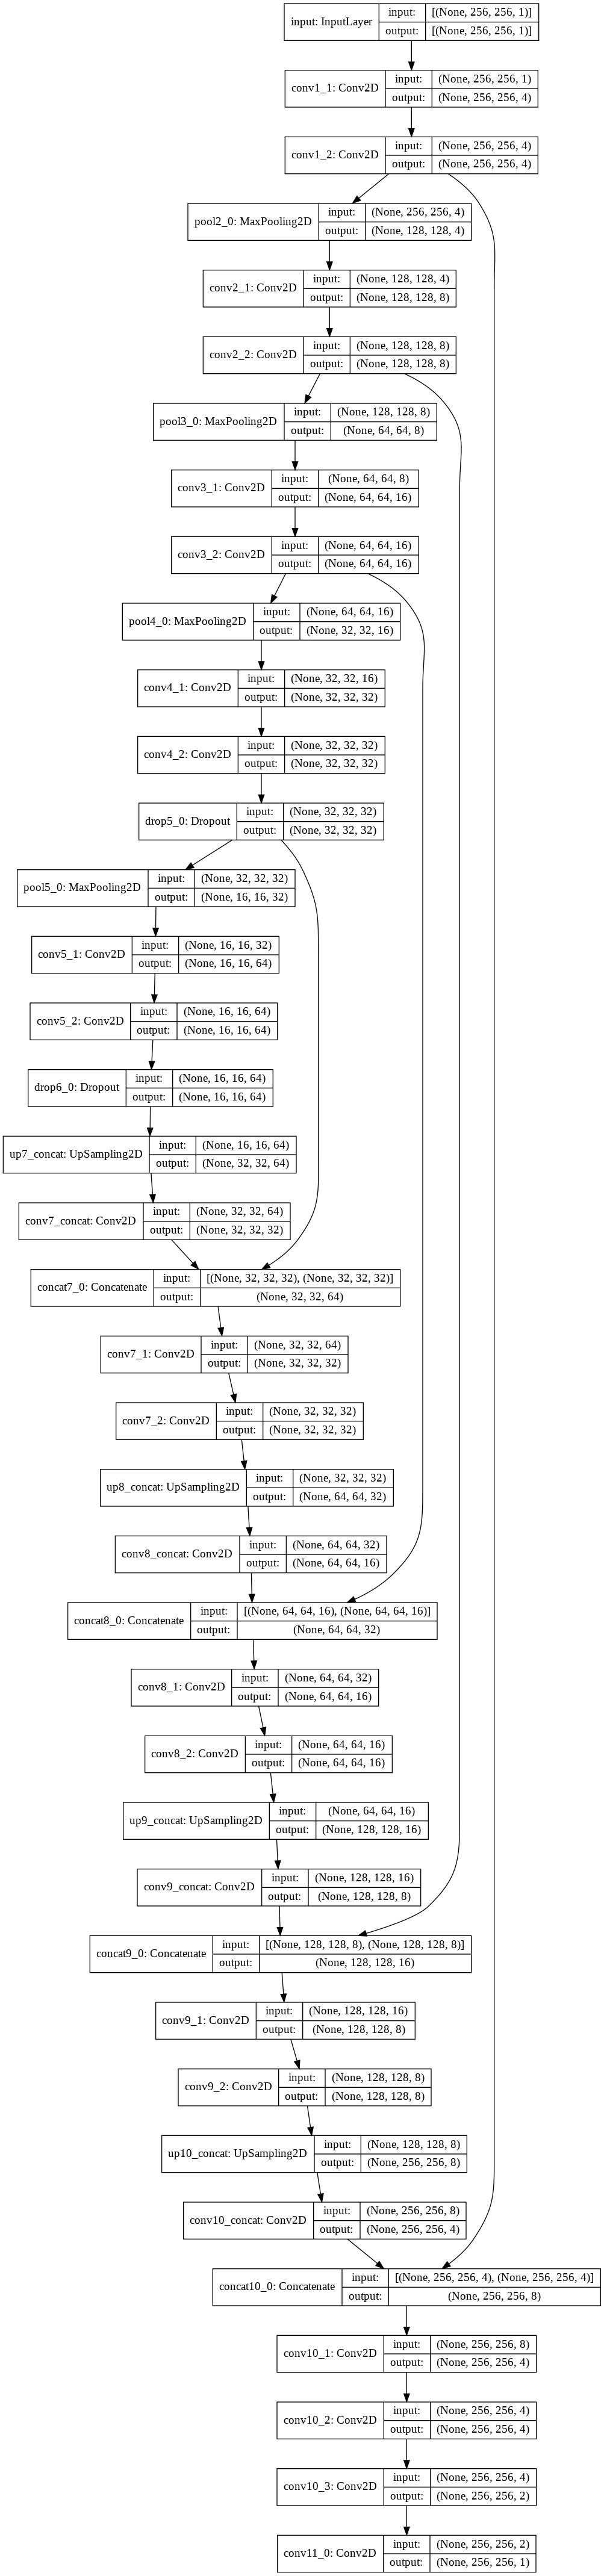

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, 'Siamese Network Architecture.png', show_shapes=True)
display.display(display.Image('Siamese Network Architecture.png'))

# Results

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>
(500, 256, 256, 1)


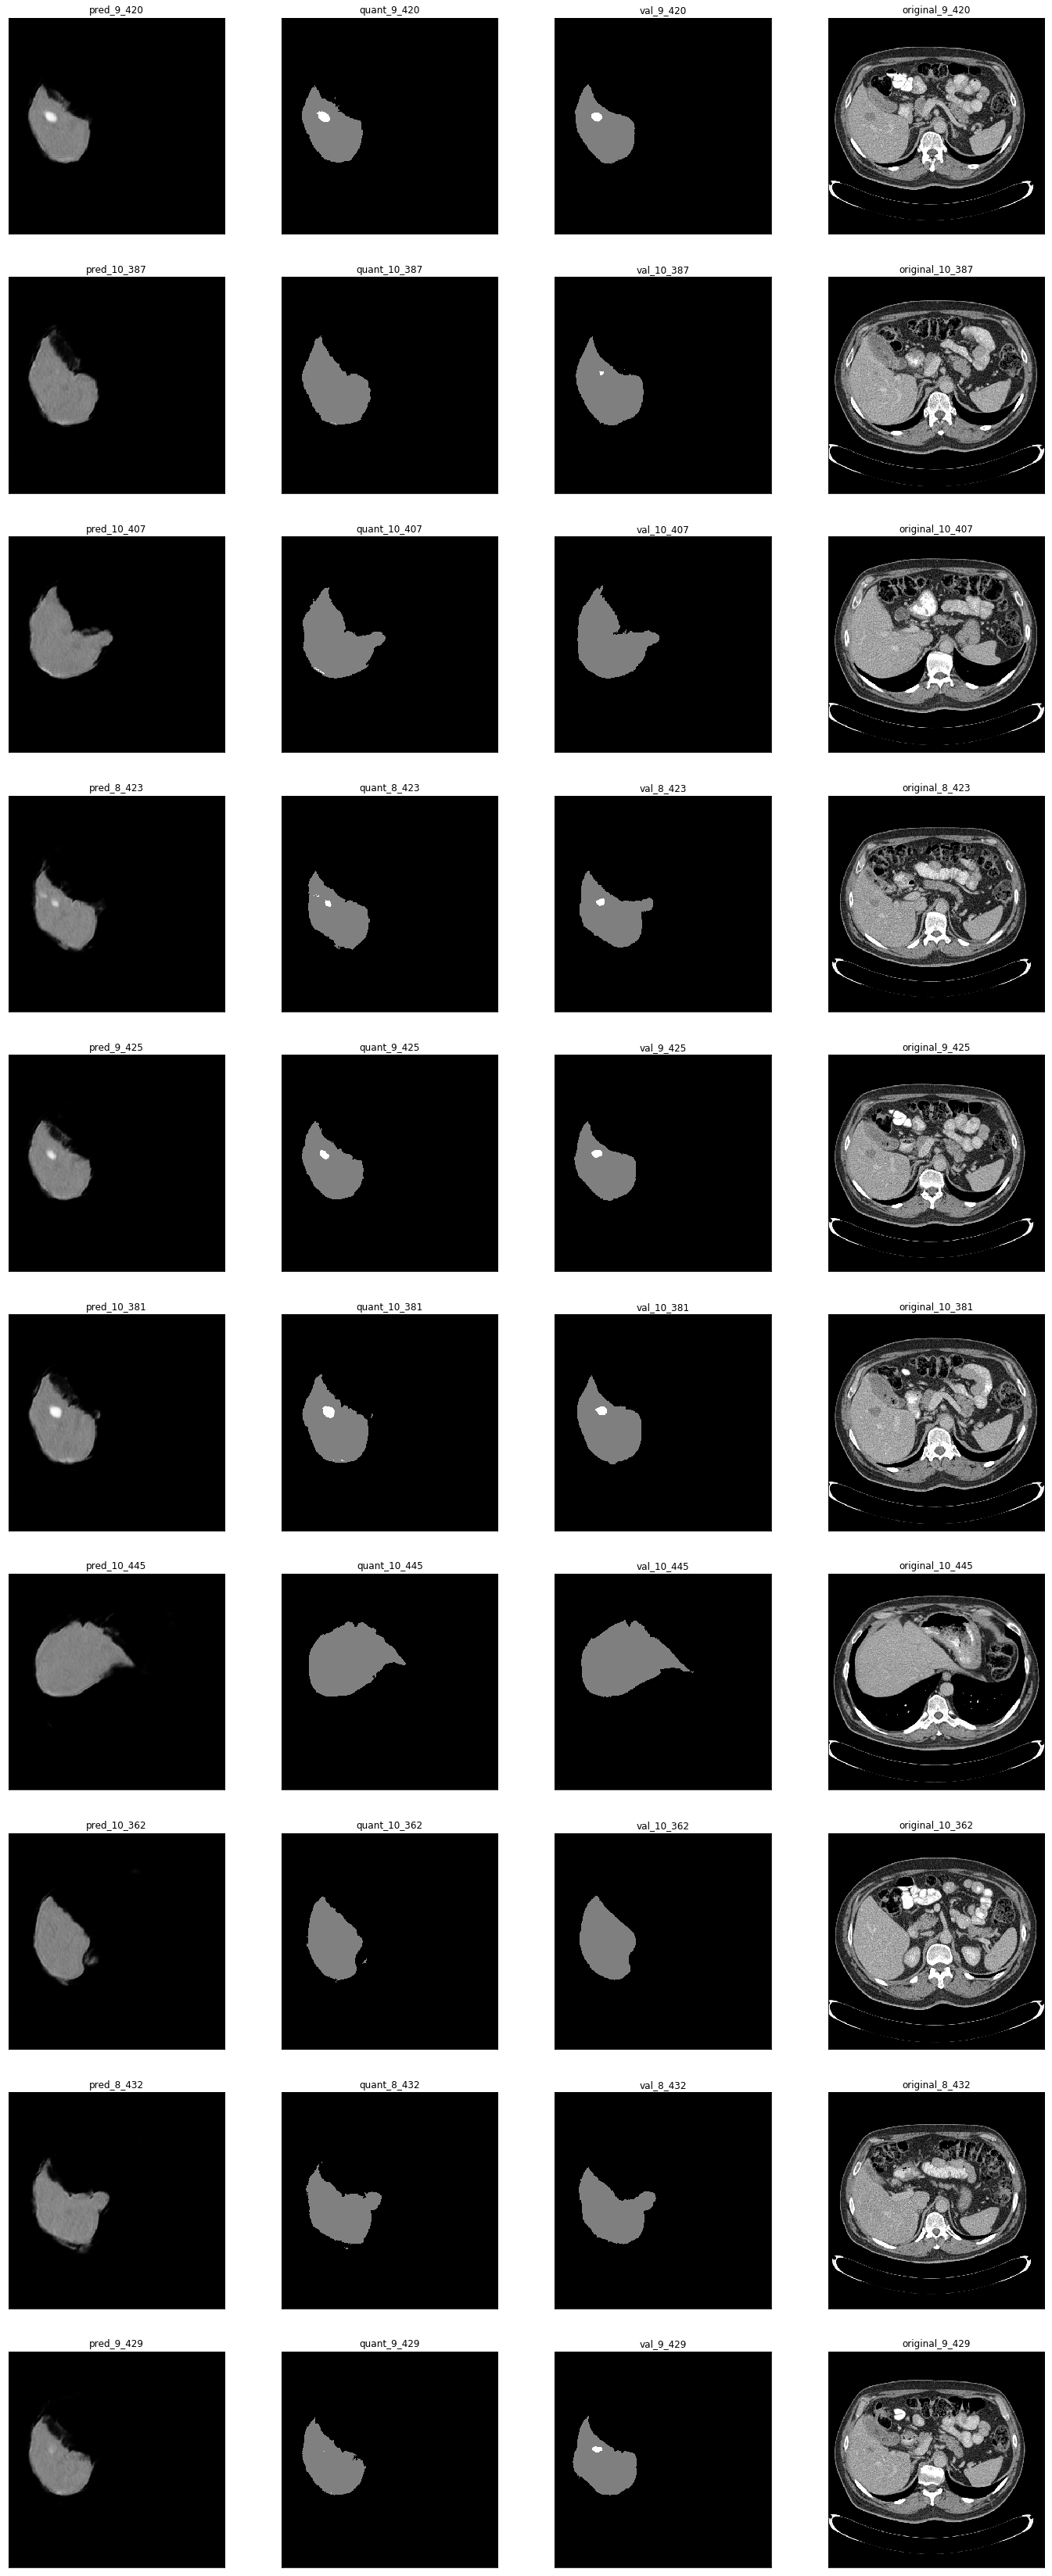

In [17]:
tmp_ds = create_ds(val_images_paths, val_masks_paths, norm=norm, resize=resize)
tmp_ds = prepare_ds(tmp_ds, batch_size=1, buffer_size=len(val_images_paths), shuffle=False)
print(tmp_ds)

pred = model.predict(
    tmp_ds,
#     batch_size=1,
    verbose=1,
    steps=len(val_images_paths),
#           max_queue_size=10,
#           workers=1,
#           use_multiprocessing=False
)
print(pred.shape)

import matplotlib.pyplot as plt
import numpy as np
from skimage import io

images_to_print=10

plt.figure(figsize=(24, images_to_print*6))
splt = 1
for i in range(images_to_print):
  plt.subplot(images_to_print, 4, splt)
  plt.imshow(np.squeeze(pred[i,:,:,:]), cmap='gray', vmin=0, vmax=1)
  plt.grid(False)
  plt.title('pred_' + image_name(val_images_paths[i]))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(images_to_print, 4, splt+1)
  plt.imshow(quantizatize(np.squeeze(pred[i,:,:,:]), 3, 170.0), cmap='gray', vmin=0, vmax=1)
  plt.grid(False)
  plt.title('quant_' + image_name(val_images_paths[i]))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(images_to_print, 4, splt+2)
  plt.imshow(io.imread(val_masks_paths[i], as_gray=True), cmap='gray', vmin=0, vmax=1)
  plt.grid(False)
  plt.title('val_' + image_name(val_masks_paths[i]))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(images_to_print, 4, splt+3)
  plt.imshow(io.imread(val_images_paths[i], as_gray=True), cmap='gray', vmin=0, vmax=1)
  plt.grid(False)
  plt.title('original_' + image_name(val_images_paths[i]))
  plt.xticks([])
  plt.yticks([])
  splt += 4